## Import packages and download dataset

In [1]:
import pickle
import numpy as np
import pandas as pd

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data = []
labels = []
for i in range(1, 6):
    batch = unpickle(f"data/cifar-10-batches-py/data_batch_{i}")
    data.append(batch[b'data'])
    labels.extend(batch[b'labels'])
X_train = np.vstack(data).reshape(-1, 3, 32, 32)
y_train = np.array(labels)
test_batch = unpickle("data/cifar-10-batches-py/test_batch")
X_test = test_batch[b'data'].reshape(-1, 3, 32, 32)
y_test = np.array(test_batch[b'labels'])
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

df_labels = pd.DataFrame(y_train, columns=["label"])
print(df_labels.head())

X_train_flat = X_train.reshape(X_train.shape[0], -1)[:20000]
X_test_flat = X_test.reshape(X_test.shape[0], -1)

Train: (50000, 3, 32, 32) (50000,)
Test : (10000, 3, 32, 32) (10000,)
   label
0      6
1      9
2      9
3      4
4      1


## Standart Scaler

In [3]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X_train_scaled = scl.fit_transform(X_train_flat)
X_test_scaled = scl.transform(X_test_flat)

## PCA

In [4]:
from sklearn.decomposition import PCA

pca =PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## Classification

**ExtraTreeClassifier**

In [7]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

extra = ExtraTreesClassifier(
    n_estimators=500,
    max_depth=30,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
extra.fit(X_train_flat[:20000], y_train[:20000])

y_pred_extra = extra.predict(X_test_flat)
print("ExtraTrees Accuracy:", accuracy_score(y_test, y_pred_extra))

ExtraTrees Accuracy: 0.4658


**Kmeans (n_clusters=200)**

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=200, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_train_flat)

c:\Users\TALABA\Desktop\cifar-10\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\TALABA\Desktop\cifar-10\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\TALABA\Desktop\cifar-10\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\TALABA\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as proc

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=5
)

knn.fit(X_train_pca, y_train[:20000])

y_pred_knn = knn.predict(X_test_pca)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

KNN Accuracy: 0.3317


**XGBOOST**

In [9]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_pca, y_train[:20000])

y_pred_xgb = xgb.predict(X_test_pca)
print("XGB Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGB Accuracy: 0.494


**Voting Classifier**

In [10]:
from sklearn.ensemble import VotingClassifier

vot_clf = VotingClassifier(
    estimators=[
        ("extra", extra),
        ("knn", knn),
        ("xgb", xgb)
    ],
    weights=[2,1,2],
    voting="hard",
    n_jobs=-1
)

vot_clf.fit(X_train_pca, y_train[:20000])

y_pred_vot = vot_clf.predict(X_test_pca)
print("Voting CLF Accuracy:", accuracy_score(y_test, y_pred_vot))

Voting CLF Accuracy: 0.4854


In [15]:
y_pred_xgb[:22], y_test[:22]

(array([3, 9, 8, 0, 6, 3, 1, 6, 2, 1, 8, 9, 3, 1, 9, 8, 5, 3, 8, 7, 1, 0]),
 array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0]))

## Visualisation

In [21]:
c0 = X_train_pca[:10000][y_pred_xgb == 5]

In [23]:
c0[0]

array([ 2.38008229e+01, -3.91704041e+01, -2.57905724e+00, -7.31525545e+00,
       -2.11896540e-02,  8.43971770e+00,  5.97088937e+00,  1.78553416e+00,
        8.37638960e-01,  6.32837978e+00, -5.40886064e+00,  9.49260445e+00,
        3.41365742e+00, -1.55709089e+00,  4.24547640e+00, -9.13235376e+00,
        2.57110770e+00,  3.56897577e+00, -5.88904278e+00, -5.80616684e+00,
       -5.16050754e+00, -1.89771912e+00, -3.21421889e+00, -5.80095951e+00,
       -1.22840912e+00,  2.26532977e+00, -3.73136837e-01, -8.34561754e+00,
        4.41428999e+00,  1.90386364e+00,  4.84791498e-01, -9.39787947e-01,
        3.44983039e+00,  3.57011701e+00,  7.05062951e+00,  2.96853696e+00,
       -1.60315908e+00, -8.07926835e-02, -3.20509466e-01,  1.53866123e+00,
       -5.63835872e+00,  3.21211560e+00, -9.56415952e-02, -1.20927209e+00,
        1.22575625e+00,  4.95535702e+00, -3.27686045e+00, -6.65823683e-01,
        2.77364975e-01, -6.26229852e-01,  1.93925509e+00, -2.74049319e+00,
        3.56299127e+00, -

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

def imshow(row, label):
    plt.imshow(np.transpose(row, (1, 2, 0)))
    plt.title(str(label))
    plt.axis('off')

c0_reshaped = c0

fig, axes = plt.subplots(8, 8, figsize=(16, 16))
for i in range(8):
    for j in range(8):
        idx = 8*i + j
        plt.sca(axes[i][j])
        imshow(c0_reshaped[idx], y_train[idx])
plt.show()

In [ ]:
class_names = [
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer',
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
]

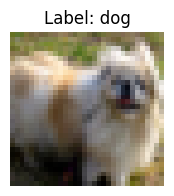

In [ ]:
plt.figure(figsize=(2,2))
n = 40
plt.imshow(np.transpose(X_train[n], (1, 2, 0)))
y_label = y_train[n]
plt.title(f"Label: {class_names[y_label]}")
plt.axis('off')
plt.show()